# **SC3000 Lab 1 - Balancing a Pole on a Cart**

## Installing Dependencies

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

## Importing Dependencies and Define Helper Functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Loading CartPole Environment

In [ ]:
env = gym.make("CartPole-v1")
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.01402526  0.00131717 -0.04524717  0.01003494]


# Task 1: Developing a RL Agent

## 1.1 Initialising the hyperparameters

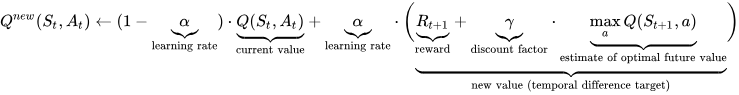 <br>
<ins>Definitions of each hyperparameters:<ins>

1. **epsilon** = Exploration rate of agent during training, which intially start at 1 representing random action. It is gradually decayed over time to make trained decisions.<br><br>
2. **epsilon_min** = Minimum value of epsilon, to ensure that the agent does not stop exploring entirely, even as it becomes more confident in its exploration.<br><br>
3. **epsilon_decay** = Rate which opsilon decreases over time, exploring less over time.<br><br>
4. **learning_rate** = α, determins the step size at which the agent updates its Q values dueing the learning process. A smaller learning rate can lead to slower learning but may converge a better solution, while a larger learning rate can lead to faster learning but may not converge to an optimal solution.<br><br>
5. **discount** = γ, discount factor quantifies the extent to which the agent values immediate rewards compared to future rewards.<br><br>
6. **EPISODES** = Number of episodes agent will play during the learning process.<br><br>
7. **actions** = [0,1]: There are two valid discrete actions: 0 for pushing the the left and 1 for pushing to the right.<br><br>
8. **observation** = Array with values corresponding to cart position, velocity and pole angle, angular velocity of a state.<br><br>
9. **window_size** = Size of the window used to discretize the observation space.<br><br>
10. **reward_arr** = List to store the reward obtained by the agent at each episode during training.

In [ ]:
#Defining hyperparameters

epsilon = 1
epsilon_min = 0.01
epsilon_decay = (epsilon - epsilon_min)/10000

learning_rate = 0.2
discount = 1
EPISODES = 10000
actions = [0,1]

observation = [50,50,50,50]
window_size = np.array([0.2,0.2,0.02,0.2])
reward_arr = []

## 1.2 Creating the Q-Table

In [ ]:
#Create Q table

q_table = np.zeros((observation + [env.action_space.n]))
q_table.shape

(50, 50, 50, 50, 2)

## 1.3 Get Discrete State

In [ ]:
#Get discrete state

def get_discrete_state(state):
  result = state/window_size + np.array([25,10,21,10])
  return tuple(result.astype(int))

print(get_discrete_state(env.step(0)[0]))

(24, 9, 18, 11)


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## 1.4 Q-Learning Process

In [ ]:
def QLearning(agent, num_episodes, learning_rate, epsilon, epsilon_decay, discount, q_table):
  # Get current state of agent
  reward_arr = []
  total_reward = 0
  for episode in range(num_episodes):
    current_state = get_discrete_state(agent.reset()[0])
    done = False
    episode_length = 0
    episode_reward = 0

    while not done:
      if np.random.random() < epsilon:
        action = np.random.randint(0, env.action_space.n)
      else:
        action = np.argmax(q_table[current_state])

      new_observation = agent.step(action)
      new_state = new_observation[0]
      new_reward = new_observation[1]
      done = new_observation[2]

      episode_length += 1
      episode_reward += new_reward

      new_discrete_state = get_discrete_state(new_state)
      max_q = np.max(q_table[new_discrete_state])
      current_q = q_table[current_state + (action,)]

      if done:
        if episode_length > 195:
          reward = 1
        else:
          reward = -1
      else:
        reward = 0.1

      new_q = (1 - learning_rate) * current_q + learning_rate * (reward + discount * max_q)
      q_table[current_state + (action,)] = new_q

      current_state = new_discrete_state

    total_reward += episode_reward
    reward_arr.append(episode_reward)

    if total_reward >= 195 and epsilon > 0.01:
      epsilon -= epsilon_decay

    if episode % 100 == 0:
      print("Episode: " + str(episode))
      print("Episode length: " + str(episode_length))
      print("Epsilon: " + str(epsilon))
      print("Mean Reward: " + str(total_reward/100))

      total_reward = 0

  agent.close()
  return q_table, reward

q_table, reward_arr = QLearning(env, EPISODES, learning_rate, epsilon, epsilon_decay, discount, q_table)

Episode: 0
Episode length: 37
Epsilon: 1
Mean Reward: 0.37
Episode: 100
Episode length: 12
Epsilon: 0.9908920000000037
Mean Reward: 21.84
Episode: 200
Episode length: 14
Epsilon: 0.9818830000000073
Mean Reward: 20.25
Episode: 300
Episode length: 23
Epsilon: 0.9730720000000108
Mean Reward: 21.44
Episode: 400
Episode length: 68
Epsilon: 0.9641620000000144
Mean Reward: 23.39
Episode: 500
Episode length: 12
Epsilon: 0.9553510000000179
Mean Reward: 22.36
Episode: 600
Episode length: 22
Epsilon: 0.9462430000000216
Mean Reward: 21.4
Episode: 700
Episode length: 14
Epsilon: 0.9373330000000252
Mean Reward: 20.54


KeyboardInterrupt: 

## 1.5 Sampling a Random State

In [ ]:
#Resetting the env and obtaining the initial observation
observation = env.reset()

#Converting the continuous observation to a discrete state
#Using the Q-table to choose the best action for the current state
discrete_state = get_discrete_state(observation[0])
action = np.argmax(q_table[discrete_state])

print(get_discrete_state(env.step(0)[0]))
print("Observation:" , observation[0] )
print("Chosen Action:", action)

(24, 9, 19, 11)
Observation: -0.020634094
Chosen Action: 0


# Task 2: Effectiveness of the RL Agent

In [ ]:
reward_arr2 = []

#Running 100 episodes
for episode in range(100):
  discrete_state = get_discrete_state(env.reset()[0])
  done = False
  episode_reward = 0

  while not done:
    action = np.argmax(q_table[discrete_state])

    new_environment = env.step(action)
    new_state = new_environment[0]
    reward = new_environment[1]
    done = new_environment[2]

    episode_reward += reward

    #Ends episode if it reaches 500
    if episode_reward > 500:
      done = True

    new_discrete_state = get_discrete_state(new_state)
    discrete_state = new_discrete_state

    if done:
      observation = env.reset()
      discrete_state = get_discrete_state(observation[0])

  reward_arr2.append(episode_reward)

env.close()

Average cumulative reward:363.72
Is my agent good enough?True


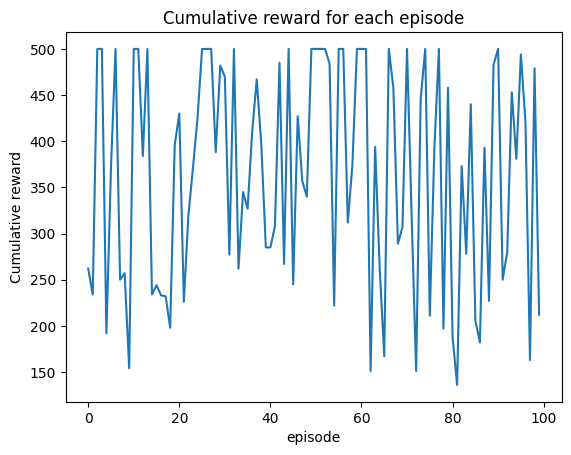

In [ ]:
print("Average cumulative reward: " + str(np.mean(reward_arr2)))
print("Is my agent good enough? " + str(np.mean(reward_arr2) > 195))
plt.plot(reward_arr2)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

# Task 3: Render One Episode Played by the Agent

In [ ]:
#Creating instance of RecordVideo
env = RecordVideo(gym.make("CartPole-v1"), "./video")

#Reset env and obtain initial observation, discrete state and intialise reward
observation = env.reset()
discrete_state = get_discrete_state(observation[0])
episode_reward = 0

done = False
while not done:
    env.render()

    #Determining action to take based on q_table values and select action with highest value
    action = np.argmax(q_table[discrete_state])

    #take chosen action in env and obtain new state, reward, and done flag
    new_env = env.step(action)
    new_state = new_env[0]
    reward = new_env[1]
    done = new_env[2]

    episode_reward += reward
    new_discrete_state = get_discrete_state(new_state)
    discrete_state = new_discrete_state

    #if episode is complete, reset env and obtain initial observation and discrete state
    if done:
        observation = env.reset()
        discrete_state = get_discrete_state(observation[0])

env.close()
show_video()
print(episode_reward)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


193.0
